In [35]:
import pandas as pd

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from Functions import dunn_index
from Functions import standardize
from Functions import pca
from Functions import tsne
from Functions import remove_outliers_iqr
from Functions import unstandardize

In [36]:
df = pd.read_csv("./Dataset/Clean.csv")
df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8636.000000        8636.000000   8636.000000       8636.000000   
mean    1601.224893           0.895035   1025.433874        604.901438   
std     2095.571300           0.207697   2167.107984       1684.307803   
min        0.000000           0.000000      0.000000          0.000000   
25%      148.095189           0.909091     43.367500          0.000000   
50%      916.855459           1.000000    375.405000         44.995000   
75%     2105.195853           1.000000   1145.980000        599.100000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8636.000000   8636.000000          8636.000000   
mean               420.843533    994.175523             0.496000   
std                917.245182   2121.458303             0.401273   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 94.785000      0.000000             0.500000   
75%                484.147500   1132.385490             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8636.000000                       8636.000000   
mean                     0.205909                          0.368820   
std                      0.300054                          0.398093   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.333333                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8636.000000       8636.000000    8636.000000   8636.000000   
mean                 0.137604          3.313918      15.033233   4522.091030   
std                  0.201791          6.912506      25.180468   3659.240379   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.250000          4.000000      18.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
count   8636.000000       8636.000000       8636.000000  
mean    1784.478099        864.304943          0.159304  
std     2909.810090       2372.566350          0.296271  
min        0.049513          0.019163          0.000000  
25%      418.559237        169.163545          0.000000  
50%      896.675701        312.452292          0.000000  
75%     1951.142090        825.496463          0.166667  
max    50721.483360      76406.207520          1.000000

In [37]:
df, scaler = standardize(df, True)

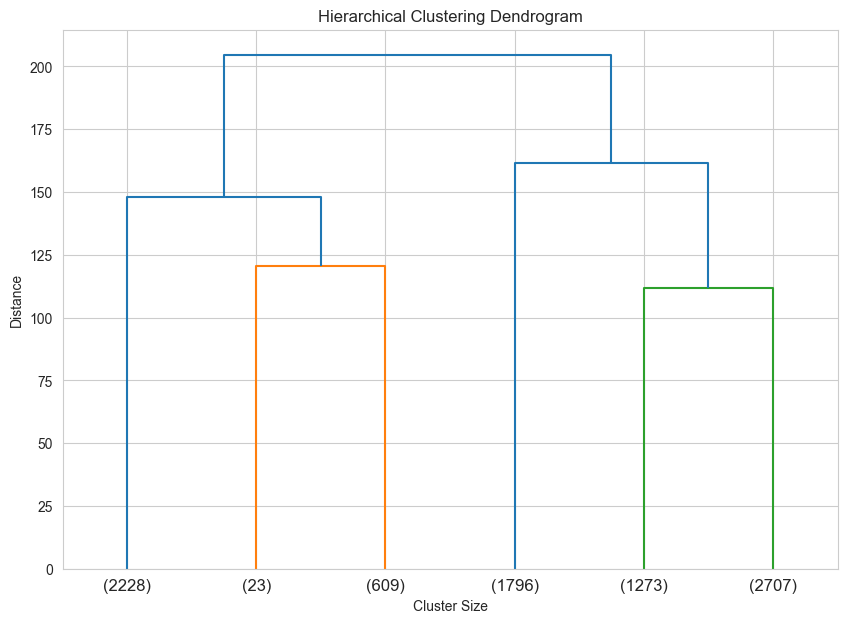

In [38]:
# Perform hierarchical clustering
linkage_matrix = linkage(df, method='ward', metric='euclidean', optimal_ordering=False)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=6)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

When looking at the dendrogram we should choose 6 classes but when we did that we got a class which just where trival (in our minds atleast). But if the supervisor which has more domain knowledge think that  6th class provides valuable information in it we could simply add it by choosing to cut at 6 classes rather than 5.

In [39]:
# threshold_distance = 200000
n_clusters = 5
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Add cluster labels
df['Cluster'] = clusters

In [40]:
# Check the resulting clusters
df_unstandardized = unstandardize(df, scaler)

# Check the resulting clusters and summary (now unstandardized)
print(df_unstandardized[['Cluster']].head())
print(df_unstandardized['Cluster'].value_counts())
cluster_summary = df_unstandardized.groupby('Cluster').mean()
print(cluster_summary)

   Cluster
0        5
1        4
2        1
3        5
4        5
Cluster
5    3980
1    2228
4    1796
3     609
2      23
Name: count, dtype: int64
             BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                   
1         587.984554           0.965491   1203.255754        542.972899   
2        4812.382778           0.956126  27505.339565      22417.452174   
3        3093.292057           0.990472   5059.375025       3176.725222   
4        3753.042840           0.961411    536.139065        311.815189   
5         950.548738           0.810685    376.408332        252.245744   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
1                    660.382401     69.956129             0.919454   
2                   5087.887391   1617.786145             0.905072   
3                   1883.635025    427.99729

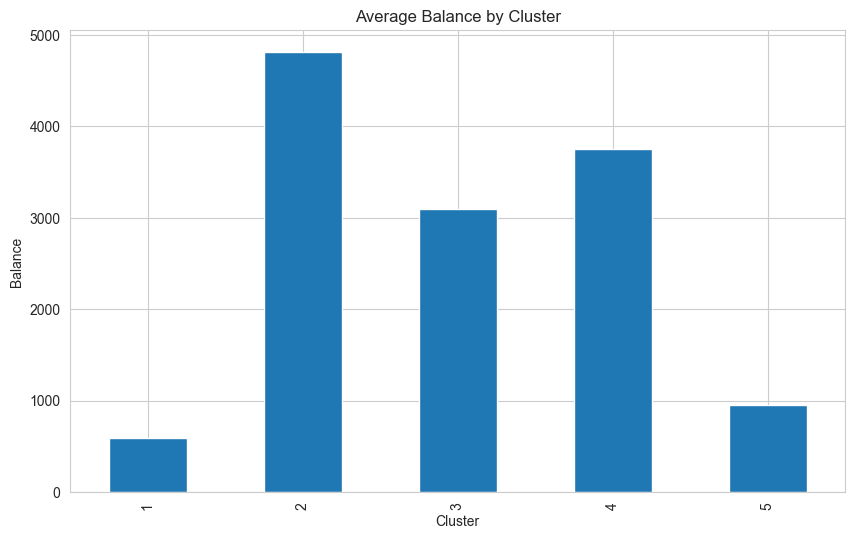

In [41]:
cluster_summary['BALANCE'].plot(kind='bar', title='Average Balance by Cluster', figsize=(10, 6))
plt.ylabel('Balance')
plt.show()

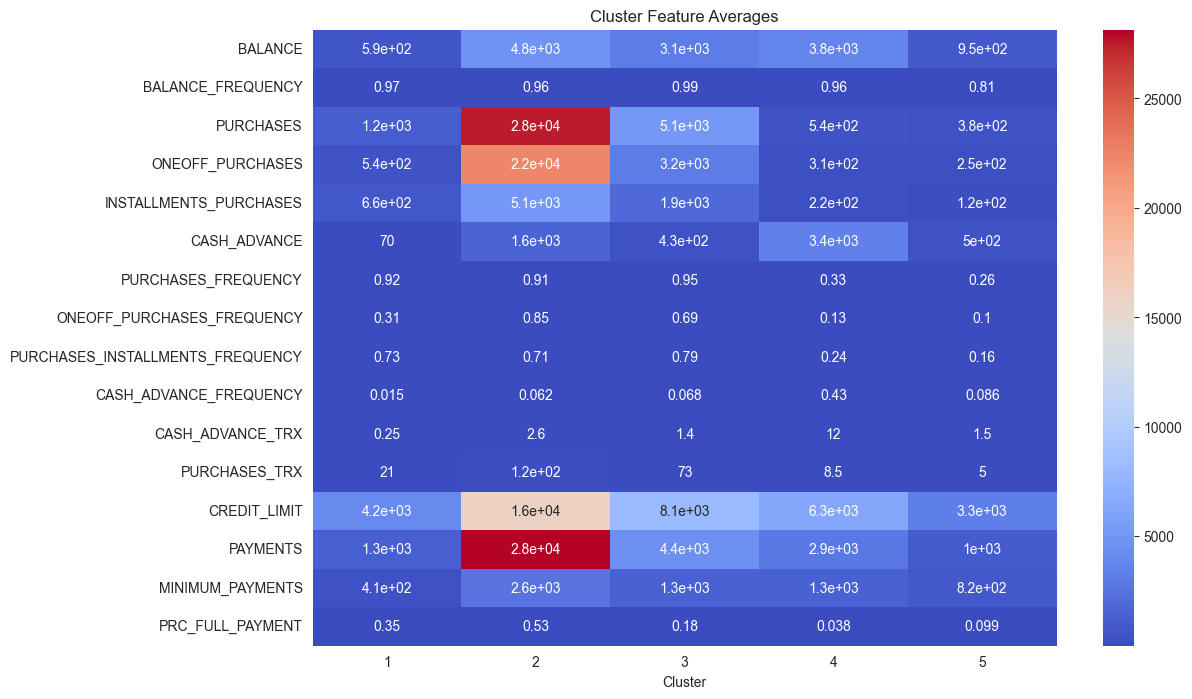

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True)
plt.title('Cluster Feature Averages')
plt.show()

In [43]:
dunn = dunn_index(df, clusters)
print(f"Dunn index: {dunn}")

Dunn index: 0.02992534352907439


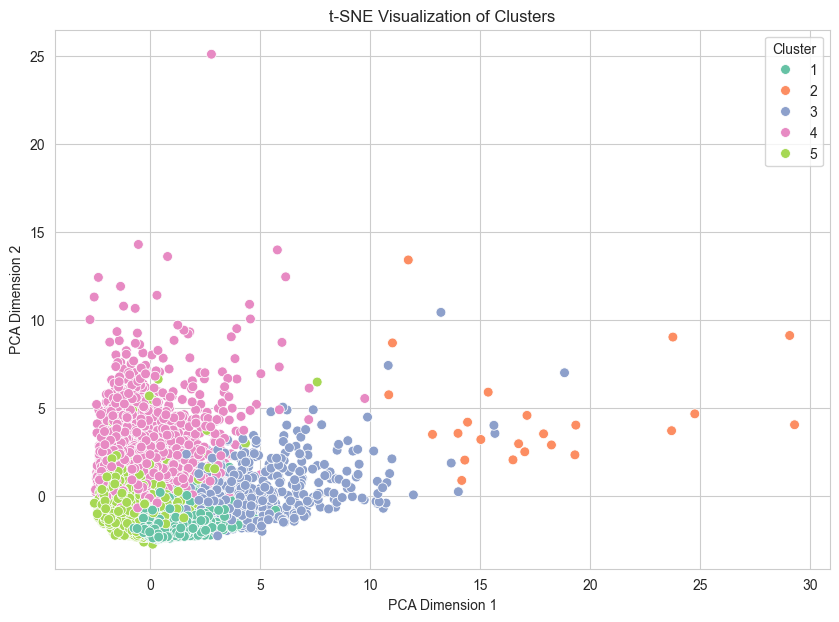

In [44]:
# Function to make 2D t-SNE dataframe
pca_df = pca(df, 2)

# Visualize with seaborn scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Cluster')
plt.show()

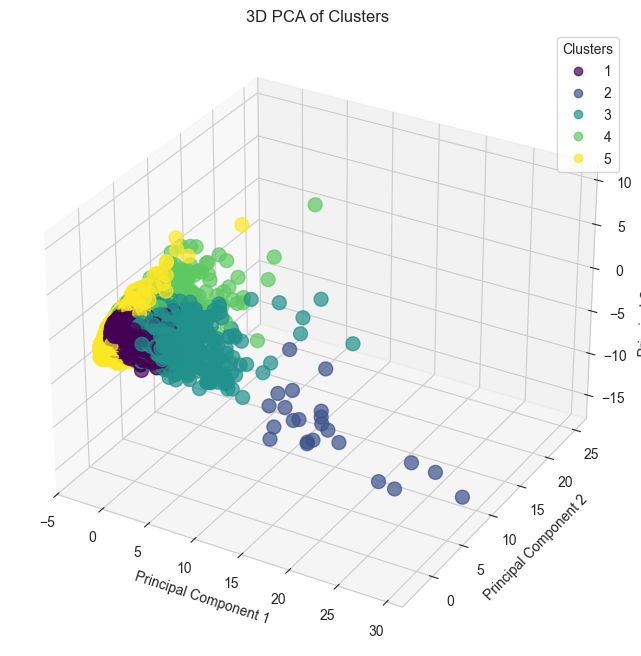

In [45]:
pca_df = pca(df,3)

#Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA of Clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [46]:
pca_df = pca(df, 3)
# Create the 3D scatter plot
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title="3D PCA of Clusters",
                    labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'},
                    color_continuous_scale='viridis')
fig.update_layout(
    width=800,
    height=600,  
    autosize=True,  
)
fig.show()

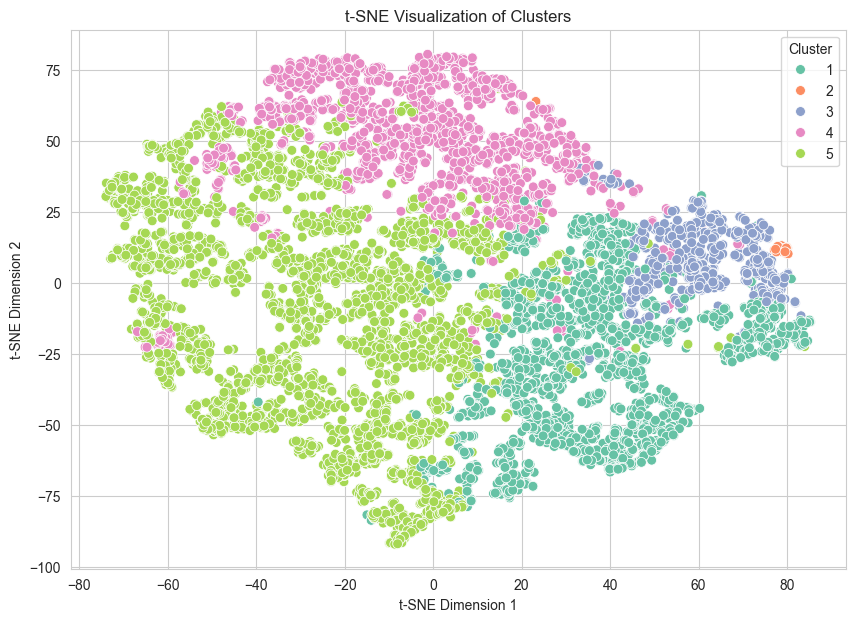

In [47]:
# Function to make 2D t-SNE dataframe
tsne_df = tsne(df, 2)

# Visualize with seaborn scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()

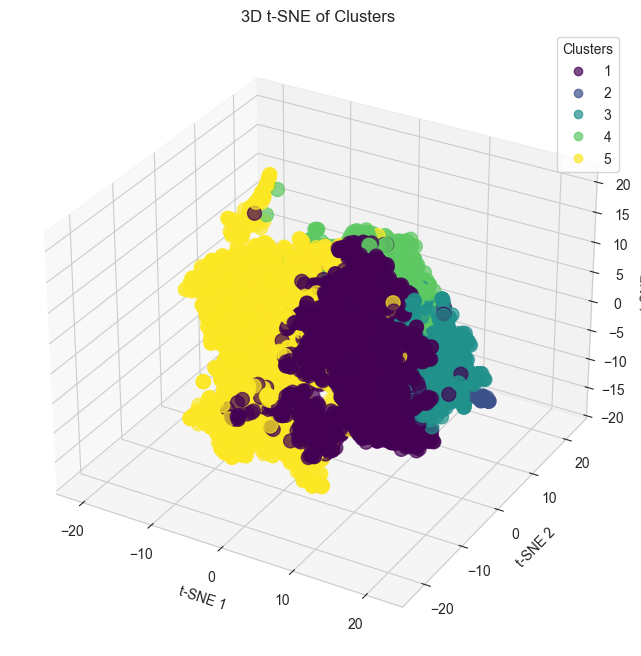

In [48]:
tsne_df = tsne(df, 3)

#Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], c=tsne_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.title('3D t-SNE of Clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [49]:
df_tsne_3d = tsne(df, 3)
# Plot 3D scatter plot using plotly
fig = px.scatter_3d(df_tsne_3d, x='TSNE1', y='TSNE2', z='TSNE3', color='Cluster', 
                    title="3D t-SNE Visualization of Clusters", color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(scene=dict(aspectmode='data'))  # Adjust 3D aspect ratio
fig.show()

In [50]:
df = remove_outliers_iqr(df, 0.15)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6246 entries, 0 to 8635
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           6246 non-null   float64
 1   BALANCE_FREQUENCY                 6246 non-null   float64
 2   PURCHASES                         6246 non-null   float64
 3   ONEOFF_PURCHASES                  6246 non-null   float64
 4   INSTALLMENTS_PURCHASES            6246 non-null   float64
 5   CASH_ADVANCE                      6246 non-null   float64
 6   PURCHASES_FREQUENCY               6246 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        6246 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  6246 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            6246 non-null   float64
 10  CASH_ADVANCE_TRX                  6246 non-null   float64
 11  PURCHASES_TRX                     6246 non-null   float64
 12  CREDIT_LIMI

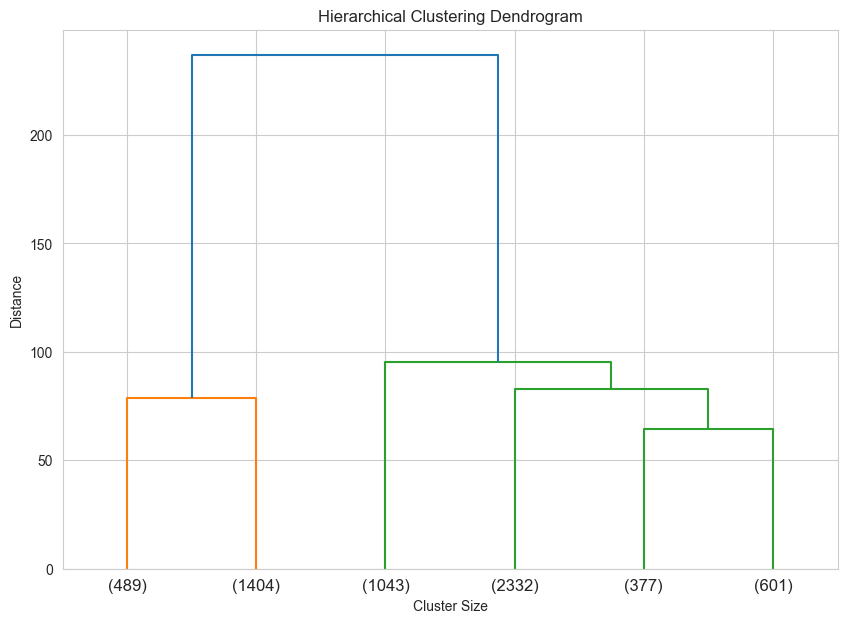

In [51]:
# Perform hierarchical clustering
linkage_matrix = linkage(df, method='ward', metric='euclidean', optimal_ordering=False)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=6)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

Splitting at 2 should give us the most value, by looking at the dendrogram

In [52]:
n_clusters = 2
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Add cluster labels
df['Cluster'] = clusters

In [53]:
# Check the resulting clusters
print(df[['Cluster']].head())
print(df['Cluster'].value_counts())
cluster_summary = df.groupby('Cluster').mean()

print(cluster_summary)

   Cluster
0        2
2        1
3        2
6        1
7        2
Cluster
2    4353
1    1893
Name: count, dtype: int64
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
1       -0.502288           0.347091  -0.029051         -0.099708   
2       -0.098350          -0.049825  -0.301441         -0.217132   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
1                      0.114242     -0.441084             1.053347   
2                     -0.313407     -0.095611            -0.533617   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
1                          0.302939                          0.896904   
2                         -0.305826                         -0.470003   

         CASH_ADVANCE_FREQUEN

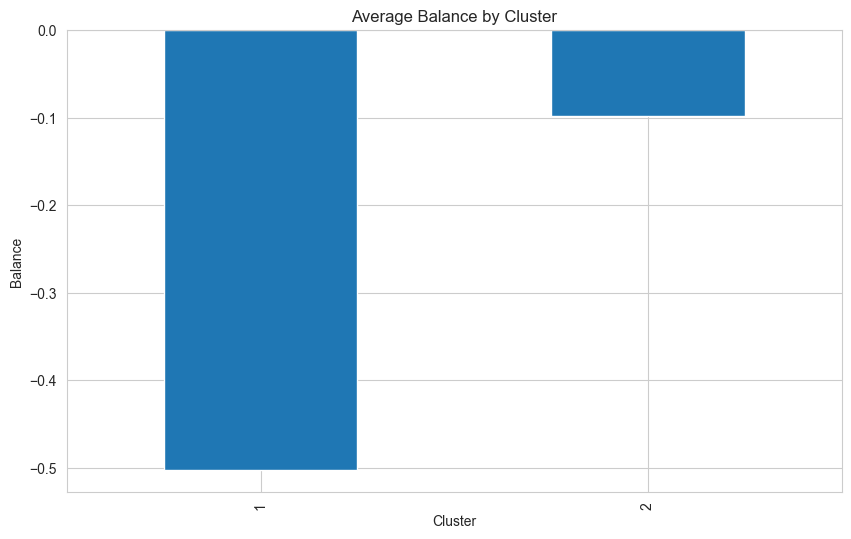

In [54]:
cluster_summary['BALANCE'].plot(kind='bar', title='Average Balance by Cluster', figsize=(10, 6))
plt.ylabel('Balance')
plt.show()

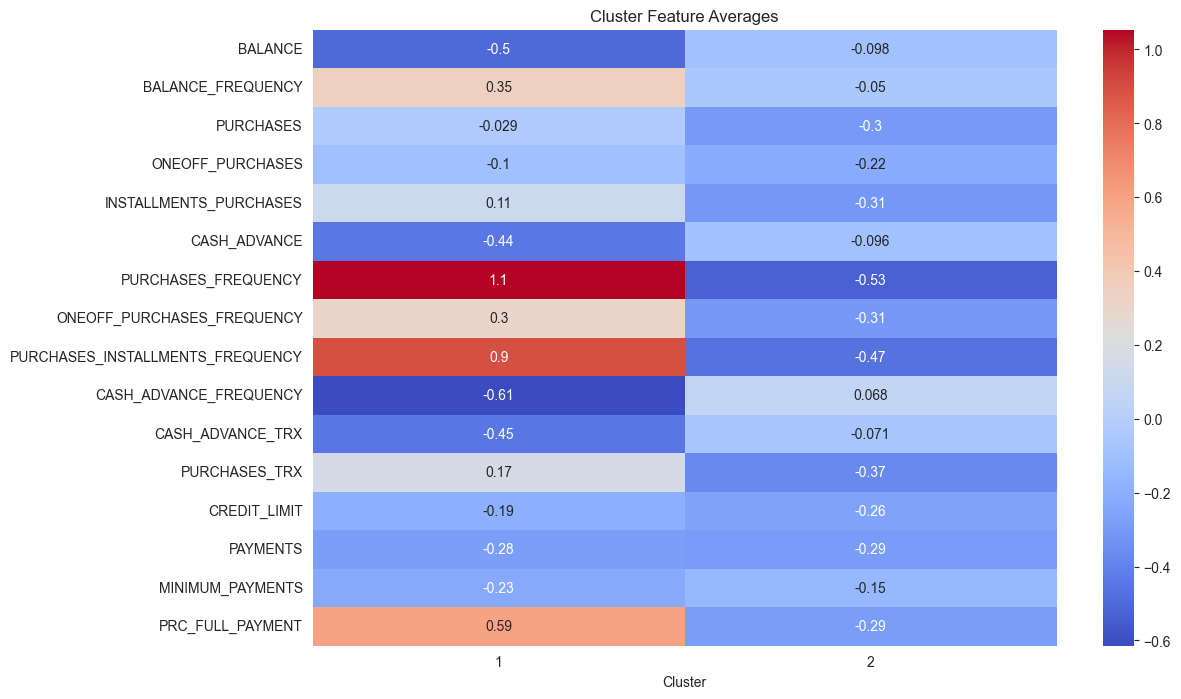

In [55]:
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True)
plt.title('Cluster Feature Averages')
plt.show()

In [56]:
dunn = dunn_index(df, clusters)
print(f"Dunn index: {dunn}")

Dunn index: 0.11765720162246628


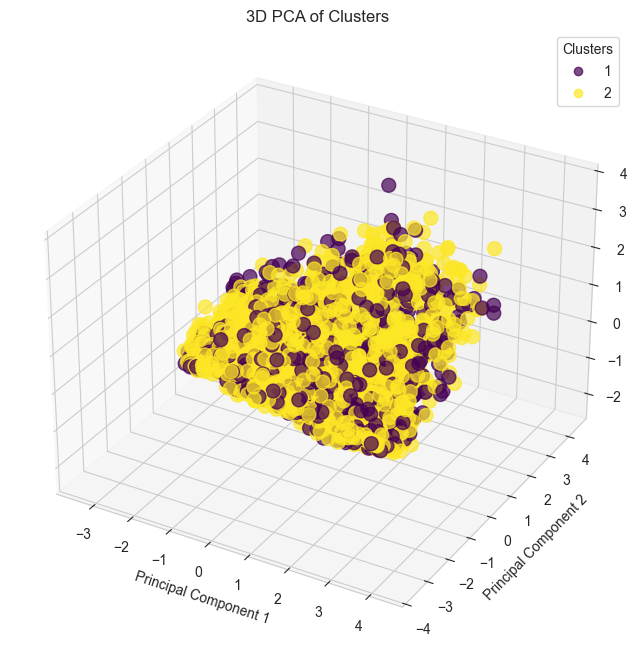

In [57]:
pca_df = pca(df,3)

#Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA of Clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [58]:
pca_df = pca(df, 3)
# Create the 3D scatter plot
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', title="3D PCA of Clusters",
                    labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'},
                    color_continuous_scale='viridis')
fig.update_layout(
    width=800,
    height=600,  
    autosize=True,  
)
fig.show()

Well removing outliers is what we can see is trivial and just messes with the data.

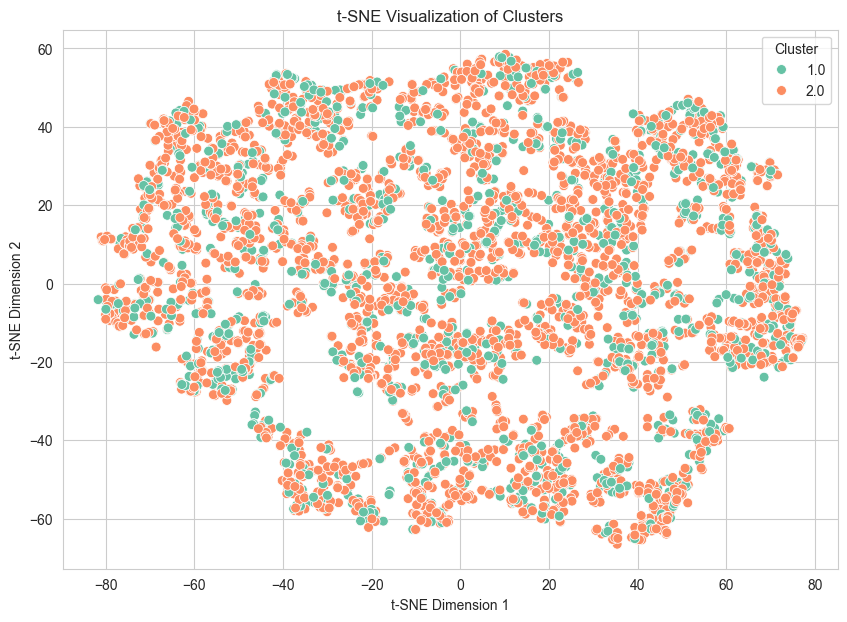

In [59]:
tsne_df = tsne(df, 2)

# Visualize with seaborn scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()